In [1]:
# Install MediaPipe library, which offers tools for face landmark detection
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 41.7 MB/s eta 0:00:00:00:0100:01


**Step 1 - Facial Landmark Extraction**

In [2]:
# Import necessary libraries
import os
import cv2
import pickle
import mediapipe as mp

# Define a function to gather facial landmarks using MediaPipe's face mesh model
def gather_landmark_data(directory):
    # Initialize MediaPipe's face mesh module
    mp_face_mesh = mp.solutions.face_mesh
    mp_drawing = mp.solutions.drawing_utils
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

    # Dictionary to store the path of each image as the key and its landmarks as the value
    landmark_data = {}

    # Iterate over each class directory (e.g., different facial expressions)
    for class_name in os.listdir(directory):
        # Iterate over each image in the class directory
        for filename in os.listdir(os.path.join(directory, class_name)):
            img_path = os.path.join(directory, class_name, filename)
            # Read the image using OpenCV
            img = cv2.imread(img_path)
            # Convert the image from BGR to RGB format
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Process the RGB image to get face landmarks
            results = face_mesh.process(img_rgb)

            # Check if landmarks are detected for the face in the image
            if results.multi_face_landmarks:
                landmarks = results.multi_face_landmarks[0]
                coords = []
                # Extract x, y, z coordinates for each landmark
                for landmark in landmarks.landmark:
                    coords.append((landmark.x, landmark.y, landmark.z))
                # Store landmarks in the dictionary
                landmark_data[img_path] = coords
            else:
                # Print a message if no face is detected in the image
                print(f"No face detected in {img_path}. Skipping...")

    # Close the face mesh module
    face_mesh.close()
    return landmark_data

# Define a function to save the landmark data to a file using pickle
def save_landmark_data(landmark_data, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(landmark_data, f)

# Specify the directory containing the facial images
directory = '/kaggle/input/facial-expressions-happiness-sadness-surprise/Face Expressions (Happy, Sad, Surprise)/train'
# Gather landmarks for each image in the specified directory
landmark_data = gather_landmark_data(directory)

# Define the output path for the pickle file and save the landmark data
output_filepath = '/kaggle/working/mp_landmark_data.pkl'
save_landmark_data(landmark_data, output_filepath)


2024-04-22 08:38:59.879964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 08:38:59.880062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 08:39:00.159478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


No face detected in /kaggle/input/facial-expressions-happiness-sadness-surprise/Face Expressions (Happy, Sad, Surprise)/train/surprise/surprised (923).jpg. Skipping...
No face detected in /kaggle/input/facial-expressions-happiness-sadness-surprise/Face Expressions (Happy, Sad, Surprise)/train/surprise/surprised (756).jpg. Skipping...
No face detected in /kaggle/input/facial-expressions-happiness-sadness-surprise/Face Expressions (Happy, Sad, Surprise)/train/surprise/surprised (234).jpg. Skipping...
No face detected in /kaggle/input/facial-expressions-happiness-sadness-surprise/Face Expressions (Happy, Sad, Surprise)/train/surprise/surprised (155).jpg. Skipping...
No face detected in /kaggle/input/facial-expressions-happiness-sadness-surprise/Face Expressions (Happy, Sad, Surprise)/train/surprise/surprised (465).jpg. Skipping...
No face detected in /kaggle/input/facial-expressions-happiness-sadness-surprise/Face Expressions (Happy, Sad, Surprise)/train/surprise/surprised (347).jpg. Skip

**Step 2 - Data Training**

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8, tree_method=hist; total time=  21.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8, tree_method=hist; total time=  21.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8, tree_method=hist; total time=  20.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0, tree_method=hist; total time=  21.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0, tree_method=hist; total time=  21.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0, tree_method=hist; total time=  20.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8, tree_method=hist; total time=  41.1s

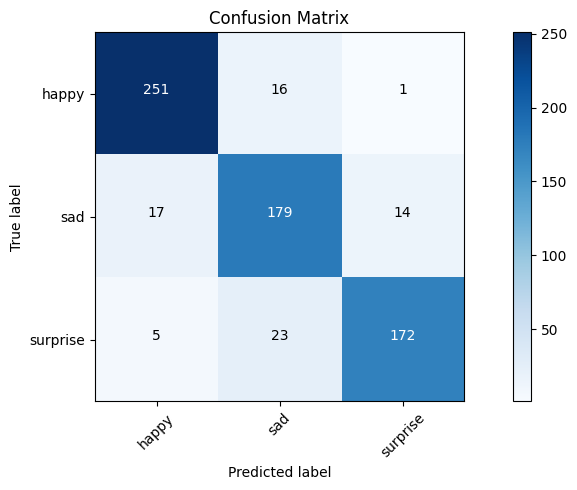

Classification Accuracy: 88.79%

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       268
           1       0.82      0.85      0.84       210
           2       0.92      0.86      0.89       200

    accuracy                           0.89       678
   macro avg       0.89      0.88      0.88       678
weighted avg       0.89      0.89      0.89       678



In [2]:
# Import the necessary libraries and modules
import pickle
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools

# Function to load landmark data from a specified path
def load_data(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Convert the landmarks dictionary to data arrays and their corresponding labels
def convert_dict_to_arrays(data_dict):
    data = []
    labels = []
    for img_path, landmarks in data_dict.items():
        data.append(np.array(landmarks).flatten())
        # Extract the disease label from the file path
        labels.append(img_path.split("/")[-2])
    return np.asarray(data), np.asarray(labels)

# Split the dataset into training and testing sets
def split_data(data, labels, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, shuffle=True, stratify=labels)
    return x_train, x_test, y_train, y_test

# Function to tune hyperparameters for the XGBoost model using GridSearch
def tune_hyperparameters(x_train, y_train):
    # Define possible values for hyperparameters
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'tree_method': ['hist'],  # Use histogram-based method
    }

    xgb = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', n_jobs=1, random_state=42)

    # Use GridSearchCV for finding the best hyperparameters
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                               cv=3, n_jobs=1, verbose=2, scoring='accuracy',
                               error_score='raise')
    grid_search.fit(x_train, y_train)
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    return grid_search.best_estimator_

# Function to evaluate the model's performance on the test set
def evaluate_model(model, x_test, y_test):
    y_predict = model.predict(x_test)
    accuracy = accuracy_score(y_predict, y_test)
    report = classification_report(y_test, y_predict)
    matrix = confusion_matrix(y_test, y_predict)
    return accuracy, report, matrix

# Plot a confusion matrix to visualize the classification results
def plot_confusion_matrix(matrix, labels, title='Confusion Matrix'):
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Display the actual counts inside the matrix cells
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Display accuracy, confusion matrix, and classification report
def plot_metrics(matrix, labels, accuracy, report):
    plt.figure(figsize=(10,5))
    plot_confusion_matrix(matrix, labels)
    plt.show()
    print(f"Classification Accuracy: {accuracy*100:.2f}%")
    print("\nClassification Report:\n", report)

# Save the trained model to a specified path for future use
def save_model(model, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump({'model': model}, f)

# Main execution begins here
try:
    # Load landmark data, convert to suitable format, and split into training and test sets
    data_dict = load_data('/kaggle/working/mp_landmark_data.pkl')
    data, labels = convert_dict_to_arrays(data_dict)
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    label_classes = label_encoder.classes_
    x_train, x_test, y_train, y_test = split_data(data, labels_encoded)

    # Tune model, evaluate it, and save the trained model
    best_model = tune_hyperparameters(x_train, y_train)
    accuracy, report, matrix = evaluate_model(best_model, x_test, y_test)
    plot_metrics(matrix, label_classes, accuracy, report)
    save_model(best_model, '/kaggle/working/mp_model.p')

# Handle any errors or exceptions
except Exception as e:
    print("An error occurred:", str(e))


**Step 3 - Testing**

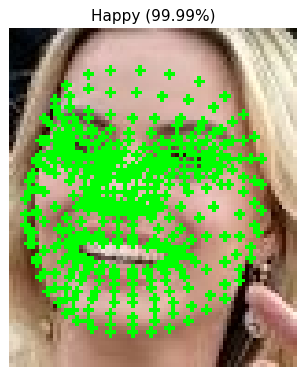

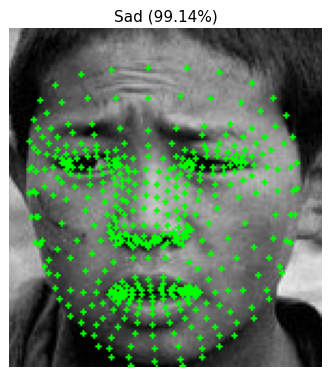

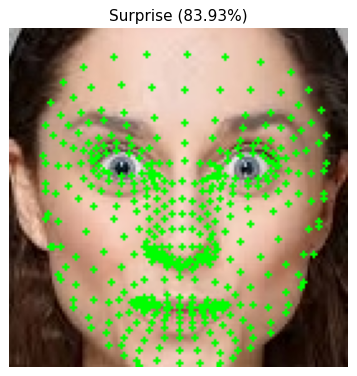

In [17]:
# Importing required modules
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import mediapipe as mp

# Load the pre-trained expression prediction model from the drive
def initialize_model():
    # Open and read the model file
    with open('/kaggle/working/mp_model.p', 'rb') as f:
        model_data = pickle.load(f)
    # Return the loaded model
    return model_data['model']

# Set up the MediaPipe FaceMesh model with static_image_mode set to True
def initialize_mediapipe_facemesh():
    return mp.solutions.face_mesh.FaceMesh(static_image_mode=True)

# Predict the expression using an image and overlay landmarks on the image
def predict_expression(img_path, clf, facemesh, label_classes):
    # Read the image from the path
    img = cv2.imread(img_path)
    # Convert the image color space to RGB and process it with FaceMesh
    results = facemesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Check if any faces are detected in the image
    if not results.multi_face_landmarks:
        print(f"No face detected in {img_path}.")
        return

    # Create a copy of the image to overlay landmarks on it
    img_with_landmarks = img.copy()

    # List to store the extracted landmarks
    landmark_data = []
    for landmarks in results.multi_face_landmarks:
        for landmark in landmarks.landmark:
            # Calculate the landmark's x and y coordinates on the image
            x, y = int(landmark.x * img.shape[1]), int(landmark.y * img.shape[0])
            # Draw the landmark as a green circle on the image copy
            cv2.circle(img_with_landmarks, (x, y), 1, (0, 255, 0), -1)
            # Append the x, y, and z values of the landmark to the list
            landmark_data.extend([landmark.x, landmark.y, landmark.z])

    # Use the trained model to predict the expression using the landmarks
    prediction_index = clf.predict([landmark_data])[0]
    # Get the predicted label string using the label_classes list
    prediction_label = label_classes[prediction_index]
    # Calculate the confidence of the prediction
    confidence = np.max(clf.predict_proba([landmark_data]))
    # Map the prediction label to its corresponding expression name
    prediction_expression = prediction_label.capitalize()

    # Display the image with landmarks and prediction details
    display_result(img_with_landmarks, prediction_expression, confidence)

# Display the image with landmarks and expression prediction using matplotlib
def display_result(img_with_landmarks, prediction_expression, confidence):
    # Calculate dpi for a desired width of 500 pixels
    dpi = 550 / 6
    # Create a new figure with calculated dpi
    plt.figure(dpi=dpi)
    plt.imshow(cv2.cvtColor(img_with_landmarks, cv2.COLOR_BGR2RGB))
    # Set the title to show the predicted expression and confidence
    plt.title(f"{prediction_expression} ({confidence*100:.2f}%)")
    # Hide the axis values
    plt.axis('off')
    # Show the image
    plt.show()

# Initialize the expression prediction model and the MediaPipe FaceMesh model
clf = initialize_model()
facemesh = initialize_mediapipe_facemesh()
label_classes = ['happy', 'sad', 'surprise']

# Test the model using an image from the drive
predict_expression('/kaggle/input/facial-expressions-happiness-sadness-surprise/Face Expressions (Happy, Sad, Surprise)/test/happy/happy (1).jpg', clf, facemesh, label_classes)
predict_expression('/kaggle/input/facial-expressions-happiness-sadness-surprise/Face Expressions (Happy, Sad, Surprise)/test/sad/sad (7).jpg', clf, facemesh, label_classes)
predict_expression('/kaggle/input/facial-expressions-happiness-sadness-surprise/Face Expressions (Happy, Sad, Surprise)/test/surprise/surprise (3).jpg', clf, facemesh, label_classes)
